# NIPS Paper Implementation Challenge :

## A Simple Neural Network Module for Relational Reasoning 
## Implemented in MXNet

Link to paper : [Arxiv](https://arxiv.org/abs/1706.01427) | [pdf](https://arxiv.org/pdf/1706.01427)

Article about the model : [https://deepmind.com/blog/neural-approach-relational-reasoning/](https://deepmind.com/blog/neural-approach-relational-reasoning/)

Identifying relations between different things a.k.a "connecting the dots" is something very innate for humans. 
In this paper, as mentioned in the article above, DeepMind has tried to give Neural Networks a similar ability - to reason about entities and their relations from unstructured data.

### About this implementation 
This implementation tries to replicate the results in the paper for the sort-of-clevr dataset. The code for generating the dataset has been borrowed from [here](https://github.com/kimhc6028/relational-networks/blob/master/sort_of_clevr_generator.py).

[**Apache MXNet**](https://mxnet.apache.org/) is used as the framework of choice, specifically MXNet's symbolic interface.

In [15]:
#framework imports

%matplotlib inline
import matplotlib.pyplot as plt

import logging
logging.getLogger().setLevel(logging.INFO)

import numpy as np
import mxnet as mx

In [2]:
from data_utils import load_data

In [22]:
# this loads the data

rel_train, rel_test, norel_train, norel_test = load_data() 
# rel_train and rel_test being are relational questions and 
# norel_train and norel_test are non-relational questions
# each of these is a dictionary with keys 'img','qst' and 'ans' which have the data

loading data...
processing data...


Let's take a closer look at the data :

In [9]:
print(len(rel_train["qst"]), len(rel_test["qst"]))

98000 2000


In [10]:
print(len(norel_train["qst"]), len(norel_test["qst"]))

98000 2000


Let's load a sample image, question and answer from the dataset

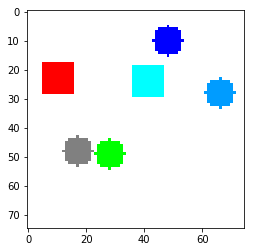

In [28]:
sample = 40  # any data index to view from the dataset
image = np.array(rel_train['img'][sample])
plt.imshow(np.moveaxis(image,0,-1))

The question is encoded as a vector with the first 6 places signifying the one-hot vector of the colour (r,g,b,o,k,y) next 2 for question type (non-relational,relational) and the next 3 for question subtype

In [29]:
question = rel_train['qst'][sample]
print(question)

[ 0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.]


Answer is one of : [yes, no, rectangle, circle, r, g, b, o, k, y]

In [31]:
answer = rel_train['ans'][sample]
print(answer)

3


## Baseline model

First we will setup some factory functions which abstract the common model architectures

In [32]:
# Basic Conv + BN + ReLU factory
def ConvFactory(data, num_filter, kernel, stride=(1,1), pad=(0, 0), act_type="relu"):
    # there is an optional parameter ```workspace``` may influece convolution performance
    # here its set to 6144MB, but you may need to set a smaller value (256MB) if less memory is available
    conv = mx.symbol.Convolution(data=data, workspace=6144,
                                 num_filter=num_filter, kernel=kernel, stride=stride, pad=pad)
    bn = mx.symbol.BatchNorm(data=conv)
    act = mx.symbol.Activation(data = bn, act_type=act_type)
    return act

In [33]:
# 4 convolutional layers extract the features from the image
def convModel(data):
    conv1 = ConvFactory(data=data, kernel=(3,3), stride=(2,2), pad=(1,1), num_filter=24, act_type="relu")
    conv2 = ConvFactory(data=conv1, kernel=(3,3), stride=(2,2), pad=(1,1), num_filter=24, act_type="relu")
    conv3 = ConvFactory(data=conv2, kernel=(3,3), stride=(2,2), pad=(1,1), num_filter=24, act_type="relu")
    conv4 = ConvFactory(data=conv3, kernel=(3,3), stride=(2,2), pad=(1,1), num_filter=24, act_type="relu")    
    return conv4

In [34]:
def denseModel(net):
    fc1 = mx.symbol.FullyConnected(net, num_hidden=256,name='fc1')
    act1 = mx.symbol.Activation(fc1, act_type="relu")
    fc2 = mx.symbol.FullyConnected(act1, num_hidden=256, name='fc2')
    act2 = mx.symbol.Activation(fc2, act_type="relu")
    fc3 = mx.symbol.FullyConnected(act2, num_hidden=10, name='fc3')
    return fc3

The baseline model is just some convolutional and dense layers put together :

In [38]:
def baseline_CNN_MLP_model():
    img = mx.sym.Variable('image')
    qst = mx.sym.Variable('question')
    label = mx.sym.Variable('softmax_label')
    net = convModel(img)
    net = mx.sym.Flatten(net)      # Flatten convolutional features
    net = mx.sym.Concat(net,qst)   # Add question vector to the end of the flattened convolutional features
    net = denseModel(net)          # Pass through fully connected layers
    net = mx.symbol.SoftmaxOutput(net, label=label)
    return net

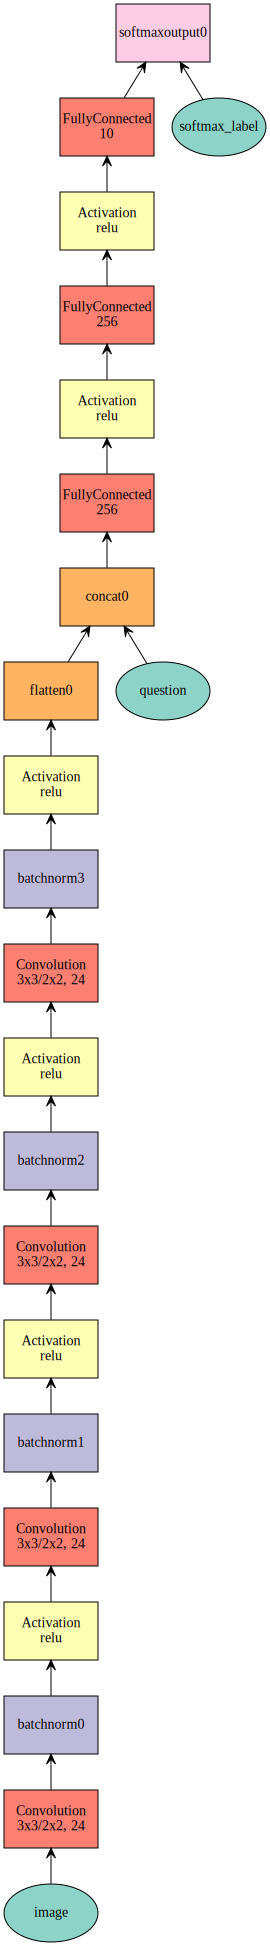

In [39]:
basenet = baseline_CNN_MLP_model()
mx.viz.plot_network(basenet)

In [66]:
batch_size = 64
print("making data iterators...")
# iterators over the combined relational and non-relational questions
combined_train_iter = mx.io.NDArrayIter(
                data={
                    'image': rel_train['img']+norel_train['img'],
                    'question': rel_train['qst']+norel_train['qst'],
                    },
                label={'softmax_label': rel_train['ans']+norel_train['ans']},
                batch_size=batch_size,
                shuffle=True
            )

combined_test_iter = mx.io.NDArrayIter(
                data={
                    'image': rel_test['img']+norel_test['img'],
                    'question': rel_test['qst']+norel_test['qst'],
                    },
                label={'softmax_label': rel_test['ans']+norel_test['ans']},
                batch_size=batch_size,
                shuffle=True
            )

making data iterators...


In [69]:
# reset train_iter to the beginning
combined_train_iter.reset()

# create a module
mod = mx.mod.Module(symbol=basenet,
                    context=mx.gpu(),
                    data_names=['image','question'],
                    label_names=['softmax_label'])

# fit the module
mod.fit(combined_train_iter,
        eval_data=combined_test_iter,
        optimizer='adam',
        optimizer_params={'learning_rate':0.001},
        eval_metric='acc',
        num_epoch=30)

INFO:root:Epoch[0] Train-accuracy=0.466852
INFO:root:Epoch[0] Time cost=11.357
INFO:root:Epoch[0] Validation-accuracy=0.519593
INFO:root:Epoch[1] Train-accuracy=0.620613
INFO:root:Epoch[1] Time cost=11.306
INFO:root:Epoch[1] Validation-accuracy=0.599702
INFO:root:Epoch[2] Train-accuracy=0.678114
INFO:root:Epoch[2] Time cost=11.440
INFO:root:Epoch[2] Validation-accuracy=0.683036
INFO:root:Epoch[3] Train-accuracy=0.686123
INFO:root:Epoch[3] Time cost=11.519
INFO:root:Epoch[3] Validation-accuracy=0.432292
INFO:root:Epoch[4] Train-accuracy=0.691010
INFO:root:Epoch[4] Time cost=11.613
INFO:root:Epoch[4] Validation-accuracy=0.442708
INFO:root:Epoch[5] Train-accuracy=0.695846
INFO:root:Epoch[5] Time cost=11.621
INFO:root:Epoch[5] Validation-accuracy=0.618552
INFO:root:Epoch[6] Train-accuracy=0.700396
INFO:root:Epoch[6] Time cost=11.610
INFO:root:Epoch[6] Validation-accuracy=0.689732
INFO:root:Epoch[7] Train-accuracy=0.704737
INFO:root:Epoch[7] Time cost=11.646
INFO:root:Epoch[7] Validation-ac

In [70]:
# overall baseline accuracy
mod.score(combined_test_iter,eval_metric='acc')

[('accuracy', 0.63988095238095233)]

#### We get a baseline accuracy of around 63.9%

In [72]:
# get accuracy score for Non Relational questions
only_norel_test_iter = mx.io.NDArrayIter(
                data={
                    'image': norel_test['img'],
                    'question': norel_test['qst'],
                    },
                label={'softmax_label': norel_test['ans']},
                batch_size=batch_size,
                shuffle=True
            )
mod.score(only_norel_test_iter,eval_metric='acc')

[('accuracy', 0.59912109375)]

In [74]:
# get accuracy score for Non Relational questions
only_rel_test_iter = mx.io.NDArrayIter(
                data={
                    'image': rel_test['img'],
                    'question': rel_test['qst'],
                    },
                label={'softmax_label': rel_test['ans']},
                batch_size=batch_size,
                shuffle=True
            )
mod.score(only_rel_test_iter,eval_metric='acc')

[('accuracy', 0.68310546875)]

In [75]:
mod.save_checkpoint("baselineModel",30)

INFO:root:Saved checkpoint to "baselineModel-0030.params"


## Next lets get on with the Relation Network

The objects considered for finding relation are the 25 convolutional feature outputs(5x5) with 24 kernels from the 4 convolutional layers. A co-ordinate vector is added along with the 24 kernels to add spatial information.

In the Visual QA Sort-of-CLEVR Model the Relation Layer is defined as:
$$\text{RN}(O) = f_{\theta} (\sum_{i,j}{g_{\theta}(o_i,o_j,q)})$$
The $f_{\theta}$ and $g_{\theta}$ functions are layers of densely connected layers. As described by the authors, the $f_{\theta}$ function consists of three layer Dense layer consisting of 256, 256, and 10 units. The convolutional layer remains the same, while the $g_{\theta}$ consists of four layers consisting of 256 units each layer with ReLU activation.

In [48]:
#functions for adding co-ordinate information
def cvt_coord(i):
    return [(i/5-2)/2.,(i%5-2/2.)]

def get_coord_tensors(size):
    np_coord_tensors = np.zeros(shape = (size, 25, 2)) #64 should be in args.batchsize
    for i in range(25):
        np_coord_tensors[:,i,:] = np.array(cvt_coord(i))
    return np_coord_tensors

In [42]:
def relation_net_model():
    img = mx.sym.Variable('image')
    qst = mx.sym.Variable('question')
    label = mx.sym.Variable('softmax_label')
    coord_tensor = mx.sym.Variable('coord_tensor')
    
    net = convModel(img)                                         #B.24.5.5
    
    net = mx.sym.reshape(net,shape=(0,24,25))                    #B.24.25
    net = mx.sym.transpose(net,axes=(0,2,1))                     #B.25.24
    
    #add coordinate information
    net = mx.sym.concat(net, coord_tensor,dim=2)                 #B.25.24+2
    
    #cast all pais against each other
    x_i = mx.sym.expand_dims(net,axis=1)                         #B.1.25.26
    x_i = mx.sym.repeat(x_i,repeats=25,axis=1)                   #B.25.25.26
    
    x_j = mx.sym.expand_dims(net,axis=2)                         #B.25.1.26
    x_j = mx.sym.repeat(x_j,repeats=25,axis=2)                   #B.25.25.26
    
    x_full = mx.sym.Concat(x_i,x_j,dim=3)                        #B.25.25.2*26
    
    #repeating questions to add with object pairings
    qst = mx.sym.expand_dims(qst,axis=1)                         #B.1.11
    qst = mx.sym.repeat(qst,repeats=25,axis=1)                   #B.25.11
    qst = mx.sym.expand_dims(qst,axis=2)                         #B.25.1.11
    qst = mx.sym.repeat(qst,repeats=25,axis=2)                   #B.25.25.11
    
    # Add question vector to the end of all the object pairings
    x_full = mx.sym.Concat(x_full,qst,dim=3)                     #B.25.25.52+11
    x_full = mx.sym.reshape(x_full,shape=(-1,63))
    
    g_theta = mx.symbol.FullyConnected(x_full, num_hidden=256,name='g_fc1')
    g_theta = mx.symbol.Activation(g_theta, act_type="relu")
    g_theta = mx.symbol.FullyConnected(g_theta, num_hidden=256, name='g_fc2')
    g_theta = mx.symbol.Activation(g_theta, act_type="relu")
    g_theta = mx.symbol.FullyConnected(g_theta, num_hidden=256, name='g_fc3')
    g_theta = mx.symbol.Activation(g_theta, act_type="relu")
    g_theta = mx.symbol.FullyConnected(g_theta, num_hidden=256, name='g_fc4')
    g_theta = mx.symbol.Activation(g_theta, act_type="relu")
    
    #reshape again and sum
    g_theta = mx.sym.reshape(g_theta,shape=(-1,25*25,256))
    sum_g_theta = mx.sym.sum(g_theta,axis=1)
    
    f_phi = mx.symbol.FullyConnected(sum_g_theta, num_hidden=256, name='f_fc1')
    f_phi = mx.symbol.Activation(f_phi, act_type="relu")
    f_phi = denseModel(f_phi)
    out = mx.symbol.SoftmaxOutput(f_phi, label=label)
    return out

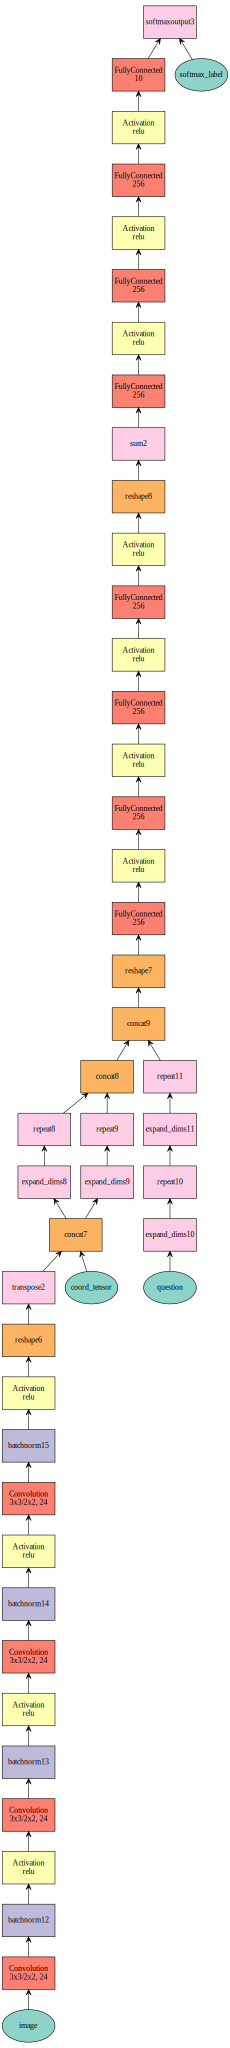

In [54]:
relationNet = relation_net_model()
mx.viz.plot_network(relationNet)

In [55]:
batch_size = 64
print("making data iterators...")
# iterators over the combined relational and non-relational questions
# this time along with the co-ordinate tensor
combined_train_iter = mx.io.NDArrayIter(
                data={
                    'image': norel_train['img']+rel_train['img'],
                    'question': norel_train['qst']+rel_train['qst'],
                    'coord_tensor':get_coord_tensors(len(rel_train['img']+norel_train['img']))
                    },
                label={'softmax_label': norel_train['ans']+rel_train['ans']},
                batch_size=batch_size,
                shuffle=True
            )

combined_test_iter = mx.io.NDArrayIter(
                data={
                    'image': norel_test['img']+rel_test['img'],
                    'question': norel_test['qst']+rel_test['qst'],
                    'coord_tensor':get_coord_tensors(len(rel_test['img']+norel_test['img']))
                    },
                label={'softmax_label': norel_test['ans']+rel_test['ans']},
                batch_size=batch_size,
                shuffle=True
            )
print("Done!")

making data iterators...
Done!


In [57]:
# reset train_iter to the beginning
combined_train_iter.reset()

# create a module
rnmod = mx.mod.Module(symbol=relationNet,
                    context=mx.gpu(),
                    data_names=['image','question','coord_tensor'],
                    label_names=['softmax_label'])

# fit the module
rnmod.fit(combined_train_iter,
        eval_data=combined_test_iter,
        optimizer='adam',
        optimizer_params={'learning_rate':0.001},
        eval_metric='acc',
        num_epoch=30)

INFO:root:Epoch[0] Train-accuracy=0.455487
INFO:root:Epoch[0] Time cost=64.617
INFO:root:Epoch[0] Validation-accuracy=0.468502
INFO:root:Epoch[1] Train-accuracy=0.470224
INFO:root:Epoch[1] Time cost=64.572
INFO:root:Epoch[1] Validation-accuracy=0.480903
INFO:root:Epoch[2] Train-accuracy=0.471678
INFO:root:Epoch[2] Time cost=64.593
INFO:root:Epoch[2] Validation-accuracy=0.479911
INFO:root:Epoch[3] Train-accuracy=0.471821
INFO:root:Epoch[3] Time cost=64.555
INFO:root:Epoch[3] Validation-accuracy=0.477679
INFO:root:Epoch[4] Train-accuracy=0.470944
INFO:root:Epoch[4] Time cost=64.513
INFO:root:Epoch[4] Validation-accuracy=0.481895
INFO:root:Epoch[5] Train-accuracy=0.491282
INFO:root:Epoch[5] Time cost=64.534
INFO:root:Epoch[5] Validation-accuracy=0.527530
INFO:root:Epoch[6] Train-accuracy=0.540825
INFO:root:Epoch[6] Time cost=64.580
INFO:root:Epoch[6] Validation-accuracy=0.533482
INFO:root:Epoch[7] Train-accuracy=0.594240
INFO:root:Epoch[7] Time cost=64.647
INFO:root:Epoch[7] Validation-ac

In [64]:
# overall accuracy
rnmod.score(combined_test_iter,eval_metric='acc')

[('accuracy', 0.89930555555555558)]

In [62]:
# get accuracy score for Non Relational questions
only_norel_test_iter = mx.io.NDArrayIter(
                data={
                    'image': norel_test['img'],
                    'question': norel_test['qst'],
                    'coord_tensor':get_coord_tensors(len(norel_test['img']))
                    },
                label={'softmax_label': norel_test['ans']},
                batch_size=batch_size,
                shuffle=True
            )
rnmod.score(only_norel_test_iter,eval_metric='acc')

[('accuracy', 0.97802734375)]

In [63]:
# get accuracy score for Non Relational questions
only_rel_test_iter = mx.io.NDArrayIter(
                data={
                    'image': rel_test['img'],
                    'question': rel_test['qst'],
                    'coord_tensor':get_coord_tensors(len(rel_test['img']))
                    },
                label={'softmax_label': rel_test['ans']},
                batch_size=batch_size,
                shuffle=True
            )
rnmod.score(only_rel_test_iter,eval_metric='acc')

[('accuracy', 0.8212890625)]

In [76]:
rnmod.save_checkpoint("relationNetModel",30)

INFO:root:Saved checkpoint to "relationNetModel-0030.params"


## Results

Baseline Model(CNN + MLP) Accuracy at 30th Epoch

| Overall       |0.639880|
|---------------|--------|
| Non-Relational|0.599121|
| Relational	|0.683105|

Model with Relation Network (CNN + RN) at 30th Epoch

| Overall       |0.899305|
|---------------|--------|
| Non-Relational|0.978027|
| Relational	|0.821289|